<a href="https://colab.research.google.com/github/TheDeshBhakt/Data-Science-and-Machine-Learning/blob/master/DeepWalk_To_Find_Similar_WikipediaPages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import networkx as nx
import pandas as pd
import numpy as np

In [0]:
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

# Load Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving space_data.tsv to space_data.tsv


In [0]:
import io

data = pd.read_csv(io.BytesIO(uploaded['space_data.tsv']), sep = '\t')

In [6]:
data.head()

,source,target,depth
0,space exploration,discovery and exploration of the solar system,1
1,space exploration,in-space propulsion technologies,1
2,space exploration,robotic spacecraft,1
3,space exploration,timeline of planetary exploration,1
4,space exploration,landings on other planets,1


# Construct the Graph

In [0]:
Gp = nx.from_pandas_edgelist(data, "source", "target", edge_attr=True, create_using=nx.Graph())

In [8]:
# Check the number of nodes in graph

len(Gp)

2088

In [0]:
# Random Walk through connected nodes

def get_randomwalk(node, path_length):

    random_walk = [node]

    for i in range(path_length - 1):
      temp = list(Gp.neighbors(node))
      temp = list(set(temp) - set(random_walk))

      if len(temp) == 0:
         break

      random_node = random.choice(temp)
      random_walk.append(random_node)
      node = random_node

    return random_walk

In [12]:
get_randomwalk('space exploration', 10)

['space exploration',
 'effect of spaceflight on the human body',
 'mars analog habitats',
 'mars habitat',
 'colonization of mars',
 'newspace',
 'billionaire space race',
 'space launch market competition',
 'timeline of spaceflight',
 'outer space']

In [15]:
# get list of all nodes in graph

total_nodes = list(Gp.nodes())


random_walks = []

for k in tqdm (total_nodes):
  for i in range(5):
    random_walks.append(get_randomwalk(k, 10))

# count of sequences
len(random_walks)

100%|██████████| 2088/2088 [00:00<00:00, 11471.24it/s]


10440

In [0]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

# DeepWalk

Train the skip-gram model with the random walks

In [23]:
# train skip-gram (word2vec) model

model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)


model.train(random_walks, total_examples = model.corpus_count, epochs=10, report_delay = 2)



(489172, 505160)

In [24]:
# every node in graph is represented by a fixed length(100) vector
# Find out most similar pages to "space tourism"

model.similar_by_word('space tourism')

[('space flight participant', 0.8847322463989258),
 ('space adventures', 0.8356142044067383),
 ('reduced-gravity aircraft', 0.8305896520614624),
 ('rocketship tours', 0.8166223764419556),
 ('space tourism society', 0.8149027824401855),
 ('astronaut training', 0.813904881477356),
 ('commercial astronaut', 0.8026520013809204),
 ('micro-g environment', 0.7698603272438049),
 ('space age', 0.7671209573745728),
 ('civil aerospace medical institute', 0.7610259056091309)]

**Result is quite interesting**

It's seems that all these pages are related to Civil Space Travel related Topics.

Now, see how well our node embeddings capture the similarity between different nodes. I have handpicked a few nodes from the graph and will plot them on a 2-dimensional space.

In [0]:
# Add more term as per your requirement analysis

terms = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
         'moon landing','space food', 'food systems on space exploration missions', 
         'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
         'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
         'space adaptation syndrome', 'micro-g environment']

In [0]:
def plot_nodes(word_list):
    X = model[word_list]

    # reduce dimension

    pca = PCA(n_components=2)
    result = pca.fit_transform(X)


    plt.figure(figsize=(12,9))

    # scatter plot of the projection

    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
      plt.annotate(word, xy=(result[i,0], result[i,1]))
    plt.show()

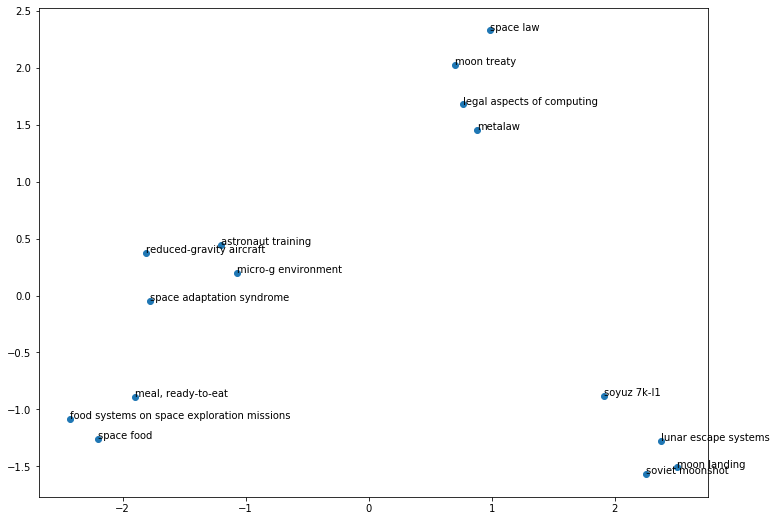

In [30]:
plot_nodes(terms)

**AMAZING**

As we see, similar Wikipedia entities are grouped together. 

For example, “soviet moonshot”, “soyuz 7k-l1”, “moon landing”, and “lunar escape systems” are all attempts made to land on the moon

**DeepWalk embeddings are so useful and important**. 

We can use these embeddings to solve multiple graph-related problems such as link prediction, node classification, question-answering system and lots more problems